In [1]:
import joblib 
import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
import hist
from hist import Hist 
from uncertainties import ufloat, unumpy
from tqdm import tqdm
import re

import sys
core_code_path = '/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/NewWorkflow'
sys.path.append(core_code_path)

from core.Calculate_SF import convert_histdict2unumpy, Construct_unumpy, Normalize_unumpy, Plot_WP, WriteSFtoPickle
from core.utils import HistBins, label_var, label_pt_bin

In [2]:
nominal_path = '/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/NewWorkflow/trained_lightGBM_new/nominal'
nominal_path = Path(nominal_path)

In [3]:
pythia_path = nominal_path / "MC_merged_hist.pkl"
data_path = nominal_path / "Data_merged_hist.pkl"

pythia = joblib.load(pythia_path)
data = joblib.load(data_path)

reweight_factor_path = nominal_path / "reweight_factor.pkl"
reweight_factor = joblib.load(reweight_factor_path)

bootstrap_Data = joblib.load('bootstrap_Data.pkl')
bootstrap_data = bootstrap_Data[1]


In [4]:

SF_bootstrap = {} 

for i_trail, bootstrap_data in tqdm(bootstrap_Data.items()):
    Extraction_Results_bootstrap = {}

    SF_label_vars = ['jet_nTracks', 'jet_trackBDT', 'GBDT_newScore']
    WPs = [0.5, 0.6, 0.7, 0.8]
    for reweight_var in SF_label_vars:

        Extraction_Results_bootstrap[reweight_var] = {}
        # Load information from MC 
        Extraction_Results_path = nominal_path / "plots" / "ADE" / "Extraction_Results" / f"{reweight_var}_Extraction_Results.pkl"
        Extraction_Results = joblib.load(Extraction_Results_path)

        for l_pt in label_pt_bin[:-1]:
            reweight_factor_pt_var = reweight_factor[l_pt][reweight_var]['quark_factor']

            f_inv = Extraction_Results[reweight_var][l_pt]['f_inv']
            
            Forward_Data = bootstrap_data[reweight_var][l_pt]['Forward_Data']
            Central_Data = bootstrap_data[reweight_var][l_pt]['Central_Data'] * reweight_factor_pt_var

            p_Forward_Data = Normalize_unumpy(Forward_Data)
            p_Central_Data = Normalize_unumpy(Central_Data)

            extract_p_Quark_Data = f_inv[0][0] * p_Forward_Data + f_inv[0][1]* p_Central_Data 
            extract_p_Gluon_Data = f_inv[1][0] * p_Forward_Data + f_inv[1][1]* p_Central_Data 

            Extraction_Results_bootstrap[reweight_var][l_pt] = {
                    "Central_Data_event_weight": bootstrap_data[reweight_var][l_pt]['Central_Data'],
                    "Forward_Data": Forward_Data,
                    "Central_Data": Central_Data,
                    "f": Extraction_Results[reweight_var][l_pt]['f'].copy(),
                    "f_inv": f_inv,
                    "p_Quark": Extraction_Results[reweight_var][l_pt]['p_Quark'].copy(),
                    "p_Gluon": Extraction_Results[reweight_var][l_pt]['p_Gluon'].copy(),
                    "p_Forward_Quark": Extraction_Results[reweight_var][l_pt]['p_Forward_Quark'].copy(),
                    "p_Central_Quark": Extraction_Results[reweight_var][l_pt]['p_Central_Quark'].copy(),
                    "p_Forward_Gluon": Extraction_Results[reweight_var][l_pt]['p_Forward_Gluon'].copy(),
                    "p_Central_Gluon": Extraction_Results[reweight_var][l_pt]['p_Central_Gluon'].copy(),
                    "extract_p_Quark_MC": Extraction_Results[reweight_var][l_pt]['extract_p_Quark_MC'].copy(),
                    "extract_p_Gluon_MC": Extraction_Results[reweight_var][l_pt]['extract_p_Gluon_MC'].copy(),
                    "extract_p_Quark_Data": extract_p_Quark_Data,
                    "extract_p_Gluon_Data": extract_p_Gluon_Data
                }
    SFs = {}
    for var in SF_label_vars:
        reweighting_var = var 
        weight_option = "quark_reweighting_weights"
        period = "ADE"
        SFs[var] = {}
        WP_cut_path = nominal_path / "plots" / "ADE" / "WP_cuts_pkls" / f"{var}_quark_reweighting_weights" / "WP_cuts.pkl"
        WP_cut = joblib.load(WP_cut_path)
        #### Draw working points 
        for WP in WPs:
            SFs[var][WP] = {}
            quark_effs_at_pt = []
            gluon_rejs_at_pt = []
            quark_effs_data_at_pt = []
            gluon_rejs_data_at_pt = []
            for ii, l_pt in enumerate(label_pt_bin[:-1]):
                extract_p_Quark_MC =  Extraction_Results_bootstrap[var][l_pt]['extract_p_Quark_MC']
                extract_p_Gluon_MC =  Extraction_Results_bootstrap[var][l_pt]['extract_p_Gluon_MC']
                extract_p_Quark_Data =  Extraction_Results_bootstrap[var][l_pt]['extract_p_Quark_Data']
                extract_p_Gluon_Data =  Extraction_Results_bootstrap[var][l_pt]['extract_p_Gluon_Data']

                cut = WP_cut[var][WP][l_pt]['idx']
                

                # for others, compare MC extracted vs Data extracted after reweighting 
                quark_effs_at_pt.append(np.sum(extract_p_Quark_MC[:cut])) 
                gluon_rejs_at_pt.append(np.sum(extract_p_Gluon_MC[cut:]))
                quark_effs_data_at_pt.append(np.sum(extract_p_Quark_Data[:cut]))
                gluon_rejs_data_at_pt.append(np.sum(extract_p_Gluon_Data[cut:]))


            SF_quark, SF_gluon = Plot_WP(WP = WP, var= var, output_path= None, 
                    period= period, reweighting_var = reweighting_var,
                    reweighting_factor= weight_option,
                    quark_effs= quark_effs_at_pt, gluon_rejs = gluon_rejs_at_pt,
                    quark_effs_data=quark_effs_data_at_pt, gluon_rejs_data = gluon_rejs_data_at_pt,
                    if_save=False)
            SFs[var][WP]["Quark"] = SF_quark
            SFs[var][WP]["Gluon"] = SF_gluon
    SF_bootstrap[i_trail] = SFs

  5%|▌         | 5/100 [02:01<38:21, 24.23s/it]


KeyboardInterrupt: 

In [16]:
def get_sf(bootstrap_data):
    Extraction_Results_bootstrap = {}

    SF_label_vars = ['jet_nTracks', 'jet_trackBDT', 'GBDT_newScore']
    WPs = [0.5, 0.6, 0.7, 0.8]
    for reweight_var in SF_label_vars:

        Extraction_Results_bootstrap[reweight_var] = {}
        # Load information from MC 
        Extraction_Results_path = nominal_path / "plots" / "ADE" / "Extraction_Results" / f"{reweight_var}_Extraction_Results.pkl"
        Extraction_Results = joblib.load(Extraction_Results_path)

        for l_pt in label_pt_bin[:-1]:
            reweight_factor_pt_var = reweight_factor[l_pt][reweight_var]['quark_factor']

            f_inv = Extraction_Results[reweight_var][l_pt]['f_inv']
            
            Forward_Data = bootstrap_data[reweight_var][l_pt]['Forward_Data']
            Central_Data = bootstrap_data[reweight_var][l_pt]['Central_Data'] * reweight_factor_pt_var

            p_Forward_Data = Normalize_unumpy(Forward_Data)
            p_Central_Data = Normalize_unumpy(Central_Data)

            extract_p_Quark_Data = f_inv[0][0] * p_Forward_Data + f_inv[0][1]* p_Central_Data 
            extract_p_Gluon_Data = f_inv[1][0] * p_Forward_Data + f_inv[1][1]* p_Central_Data 

            Extraction_Results_bootstrap[reweight_var][l_pt] = {
                    "Central_Data_event_weight": bootstrap_data[reweight_var][l_pt]['Central_Data'],
                    "Forward_Data": Forward_Data,
                    "Central_Data": Central_Data,
                    "f": Extraction_Results[reweight_var][l_pt]['f'].copy(),
                    "f_inv": f_inv,
                    "p_Quark": Extraction_Results[reweight_var][l_pt]['p_Quark'].copy(),
                    "p_Gluon": Extraction_Results[reweight_var][l_pt]['p_Gluon'].copy(),
                    "p_Forward_Quark": Extraction_Results[reweight_var][l_pt]['p_Forward_Quark'].copy(),
                    "p_Central_Quark": Extraction_Results[reweight_var][l_pt]['p_Central_Quark'].copy(),
                    "p_Forward_Gluon": Extraction_Results[reweight_var][l_pt]['p_Forward_Gluon'].copy(),
                    "p_Central_Gluon": Extraction_Results[reweight_var][l_pt]['p_Central_Gluon'].copy(),
                    "extract_p_Quark_MC": Extraction_Results[reweight_var][l_pt]['extract_p_Quark_MC'].copy(),
                    "extract_p_Gluon_MC": Extraction_Results[reweight_var][l_pt]['extract_p_Gluon_MC'].copy(),
                    "extract_p_Quark_Data": extract_p_Quark_Data,
                    "extract_p_Gluon_Data": extract_p_Gluon_Data
                }
    SFs = {}
    for var in SF_label_vars:
        reweighting_var = var 
        weight_option = "quark_reweighting_weights"
        period = "ADE"
        SFs[var] = {}
        WP_cut_path = nominal_path / "plots" / "ADE" / "WP_cuts_pkls" / f"{var}_quark_reweighting_weights" / "WP_cuts.pkl"
        WP_cut = joblib.load(WP_cut_path)
        #### Draw working points 
        for WP in WPs:
            SFs[var][WP] = {}
            quark_effs_at_pt = []
            gluon_rejs_at_pt = []
            quark_effs_data_at_pt = []
            gluon_rejs_data_at_pt = []
            for ii, l_pt in enumerate(label_pt_bin[:-1]):
                extract_p_Quark_MC =  Extraction_Results_bootstrap[var][l_pt]['extract_p_Quark_MC']
                extract_p_Gluon_MC =  Extraction_Results_bootstrap[var][l_pt]['extract_p_Gluon_MC']
                extract_p_Quark_Data =  Extraction_Results_bootstrap[var][l_pt]['extract_p_Quark_Data']
                extract_p_Gluon_Data =  Extraction_Results_bootstrap[var][l_pt]['extract_p_Gluon_Data']

                cut = WP_cut[var][WP][l_pt]['idx']
                

                # for others, compare MC extracted vs Data extracted after reweighting 
                quark_effs_at_pt.append(np.sum(extract_p_Quark_MC[:cut])) 
                gluon_rejs_at_pt.append(np.sum(extract_p_Gluon_MC[cut:]))
                quark_effs_data_at_pt.append(np.sum(extract_p_Quark_Data[:cut]))
                gluon_rejs_data_at_pt.append(np.sum(extract_p_Gluon_Data[cut:]))


            SF_quark, SF_gluon = Plot_WP(WP = WP, var= var, output_path= None, 
                    period= period, reweighting_var = reweighting_var,
                    reweighting_factor= weight_option,
                    quark_effs= quark_effs_at_pt, gluon_rejs = gluon_rejs_at_pt,
                    quark_effs_data=quark_effs_data_at_pt, gluon_rejs_data = gluon_rejs_data_at_pt,
                    if_save=False)
            SFs[var][WP]["Quark"] = SF_quark
            SFs[var][WP]["Gluon"] = SF_gluon
    return SFs

In [17]:
list_bootstrap_Data = [*bootstrap_Data.values()]

In [20]:
from concurrent.futures import ProcessPoolExecutor
import functools 
n_workers = 10 
with ProcessPoolExecutor(max_workers=n_workers) as executor:
    SFs_all = list(executor.map(get_sf, list_bootstrap_Data))


In [21]:
len(SFs_all)

100

In [33]:
SF_jet_nTrack_0p5_500 = []
for i in range(100):
    SF_jet_nTrack_0p5_500.append(unumpy.nominal_values(SFs_all[i]['jet_nTracks'][0.5]['Quark'][0]))

(array([ 4.,  8., 12.,  3., 19., 23., 10., 13.,  6.,  2.]),
 array([1.02608703, 1.02647334, 1.02685965, 1.02724596, 1.02763227,
        1.02801858, 1.02840489, 1.0287912 , 1.02917752, 1.02956383,
        1.02995014]),
 <BarContainer object of 10 artists>)

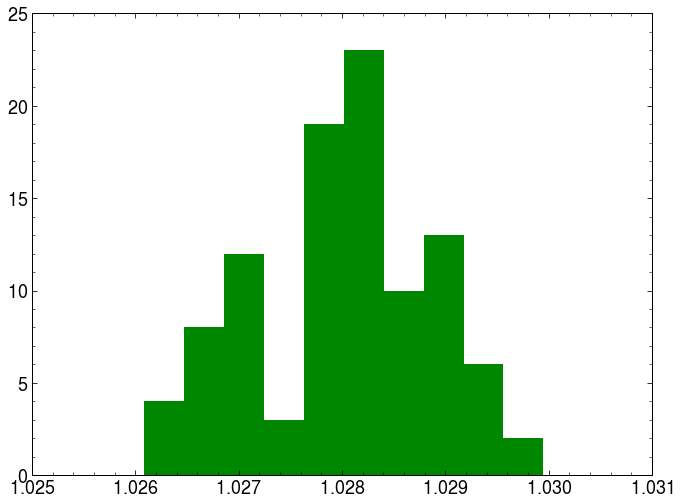

In [41]:
plt.hist(SF_jet_nTrack_0p5_500, bins=10)

In [42]:
nominal = joblib.load(nominal_path / "plots" / "ADE" / "SFs_pkls" / "jet_nTracks_quark_reweighting_weights" / "SFs.pkl")

In [44]:
nominal['jet_nTracks'][0.5]['Quark']

array([1.0279333381553586+/-0.0018586113195646565,
       1.0443329347783434+/-0.0015922765556675275,
       1.0461937516008866+/-0.0028960158934784102,
       1.033476695908774+/-0.005694787038356356,
       1.0204495764454495+/-0.010449997703414317,
       1.00974996065689+/-0.02274082580019074], dtype=object)

In [46]:
SFs_all[0]['jet_nTracks'][0.5]['Quark']

array([1.027082852802473+/-0.0018575834646214584,
       1.0443261340150394+/-0.001592412701851869,
       1.0488422593128628+/-0.0028980246305595793,
       1.0278062099788436+/-0.00569077746708615,
       1.0250975387596635+/-0.010458498707569387,
       1.0092253931800512+/-0.022834289745968007], dtype=object)

In [ ]:
SFs = {}
for var in SF_label_vars:
    reweighting_var = var 
    weight_option = "quark_reweighting_weights"
    period = "ADE"
    SFs[var] = {}
    WP_cut_path = nominal_path / "plots" / "ADE" / "WP_cuts_pkls" / f"{var}_quark_reweighting_weights" / "WP_cuts.pkl"
    WP_cut = joblib.load(WP_cut_path)
    #### Draw working points 
    for WP in WPs:
        SFs[var][WP] = {}
        quark_effs_at_pt = []
        gluon_rejs_at_pt = []
        quark_effs_data_at_pt = []
        gluon_rejs_data_at_pt = []
        for ii, l_pt in enumerate(label_pt_bin[:-1]):
            extract_p_Quark_MC =  Extraction_Results_bootstrap[var][l_pt]['extract_p_Quark_MC']
            extract_p_Gluon_MC =  Extraction_Results_bootstrap[var][l_pt]['extract_p_Gluon_MC']
            extract_p_Quark_Data =  Extraction_Results_bootstrap[var][l_pt]['extract_p_Quark_Data']
            extract_p_Gluon_Data =  Extraction_Results_bootstrap[var][l_pt]['extract_p_Gluon_Data']

            cut = WP_cut[var][WP][l_pt]['idx']
            

            # for others, compare MC extracted vs Data extracted after reweighting 
            quark_effs_at_pt.append(np.sum(extract_p_Quark_MC[:cut])) 
            gluon_rejs_at_pt.append(np.sum(extract_p_Gluon_MC[cut:]))
            quark_effs_data_at_pt.append(np.sum(extract_p_Quark_Data[:cut]))
            gluon_rejs_data_at_pt.append(np.sum(extract_p_Gluon_Data[cut:]))


        SF_quark, SF_gluon = Plot_WP(WP = WP, var= var, output_path= None, 
                period= period, reweighting_var = reweighting_var,
                reweighting_factor= weight_option,
                quark_effs= quark_effs_at_pt, gluon_rejs = gluon_rejs_at_pt,
                quark_effs_data=quark_effs_data_at_pt, gluon_rejs_data = gluon_rejs_data_at_pt,
                if_save=False)
        SFs[var][WP]["Quark"] = SF_quark
        SFs[var][WP]["Gluon"] = SF_gluon

In [ ]:
SFs['jet_nTracks'].keys()

In [ ]:
reweight_var = 'jet_nTracks'
reweight_option = 'jet_nTracks_quark_reweighting_weights'
pt = 500 

In [ ]:
reweight_factor_pt_var = reweight_factor[pt]['jet_nTracks']['quark_factor']

In [ ]:
### Get the fraction from MC 
Extraction_Results_path = nominal_path / "plots" / "ADE" / "Extraction_Results" / f"{reweight_var}_Extraction_Results.pkl"
Extraction_Results = joblib.load(Extraction_Results_path)

In [ ]:
f_inv = Extraction_Results[reweight_var][pt]['f_inv']

In [ ]:
Forward_Data = bootstrap_data[reweight_var][pt]['Forward_Data']
Central_Data = bootstrap_data[reweight_var][pt]['Central_Data'] * reweight_factor_pt_var

In [ ]:
p_Forward_Data = Normalize_unumpy(Forward_Data)
p_Central_Data = Normalize_unumpy(Central_Data)

In [ ]:
extract_p_Quark_Data = f_inv[0][0] * p_Forward_Data + f_inv[0][1]* p_Central_Data 
extract_p_Gluon_Data = f_inv[1][0] * p_Forward_Data + f_inv[1][1]* p_Central_Data 

In [ ]:
Extraction_Results_bootstrap = {}

Extraction_Results_bootstrap[var][l_pt] = {
                "Forward_Data": Forward_Data,
                "Central_Data": Central_Data,

                "f_inv": f_inv,
                "p_Quark": Extraction_Results[reweight_var][pt]['p_Quark'].copy(),
                "p_Gluon": Extraction_Results[reweight_var][pt]['p_Gluon'].copy(),
                "p_Forward_Quark": Extraction_Results[reweight_var][pt]['p_Forward_Quark'].copy(),
                "p_Central_Quark": Extraction_Results[reweight_var][pt]['p_Central_Quark'].copy(),
                "p_Forward_Gluon": Extraction_Results[reweight_var][pt]['p_Forward_Gluon'].copy(),
                "p_Central_Gluon": Extraction_Results[reweight_var][pt]['p_Central_Gluon'].copy(),
                "extract_p_Quark_MC": Extraction_Results[reweight_var][pt]['extract_p_Quark_MC'].copy(),
                "extract_p_Gluon_MC": Extraction_Results[reweight_var][pt]['extract_p_Gluon_MC'].copy(),
                "extract_p_Quark_Data": extract_p_Quark_Data,
                "extract_p_Gluon_Data": extract_p_Gluon_Data
            }